# ベイズ勉強会 Part 5 線形モデル

> ベイズ線形モデルの学習と予測の式変形を行う

- toc: true 
- badges: true
- comments: true
- categories: [bayes]
- image: images/linear_reg.gif

ベイズ勉強会資料は『ベイズ推論による機械学習入門』{% fn 1 %}を元に、途中式計算をできるだけ省略せずに行ったものです。

実数の出力値$y_n$を、入力値${\bf x}_n$の関数で表す。

## モデルの構築

### モデルの例

出力値$y_n \in \mathbb{R}$を、入力値${\bf x}_n \in \mathbb{R}^M$, パラメータ${\bf w} \in \mathbb{R}^M$, ノイズ成分$\epsilon_n \in \mathbb{R}$を使って次のモデル式で表してみる。

$$
y_n = {\bf w}^\mathrm{T} {\bf x}_n + \epsilon_n
$$

ノイズ成分$\epsilon_n$が平均ゼロのガウス分布に従っていると仮定し、次のように表す。

$$
\epsilon_n \sim \mathcal{N}(\epsilon_n | 0, \lambda^{-1})
$$

ここで$\lambda \in \mathbb{R}$は1次元ガウス分布の既知の精度パラメータとする。以上の2式はまとめて書くこともできて、

$$
p(y_n | {\bf x}_n, {\bf w}) = \mathcal{N}(y_n | {\bf w}^\mathrm{T} {\bf x}_n, \lambda^{-1})
$$

となる。

さらに学習のためにパラメータ${\bf w}$の事前分布を設定する。ベクトルを出力したいので多次元ガウス分布とすると、

$$
p({\bf w}) = \mathcal{N}({\bf w}|{\bf m}, {\bf \Lambda}^{-1})
$$

と書ける。${\bf m}$は平均パラメータ、${\bf \Lambda}$は精度行列パラメータである。

複数のデータ点をまとめたものを${\bf Y}= \{ y_1,\dots,y_N \}, {\bf X= \{ {\bf x}_1,\dots, {\bf x}_N \}}$とすれば

$$
p({\bf Y}|{\bf w}, {\bf X}) = \Pi_{n=1}^{N} p (y_n | {\bf x}_n, {\bf w})
$$

と書ける。

モデルを同時分布で書くと

$$
p({\bf Y}, {\bf X}, {\bf w}) = p({\bf w})\Pi_{n=1}^{N} p (y_n | {\bf x}_n, {\bf w})p({\bf x}_n)
$$

${\bf X}$に条件づけられた${\bf Y},{\bf w}$の同時分布で表してもよい。

$$
p({\bf Y}, {\bf w}|{\bf X}) = p({\bf w})\Pi_{n=1}^{N} p (y_n | {\bf x}_n, {\bf w})
$$



### モデルの性質の確認

事前分布の値を適当に設定すれば、パラメータ${\bf w}$をサンプリングできる。今回は${\bf x}_n$を$\{1, x, x^2, x^3 \}$の多項式ベクトルとし、平均ベクトル${\bf m}$をゼロベクトル、精度行列${\bf \Lambda}$を単位行列とする。

In [1]:
using LinearAlgebra
using Distributions
ENV["GKS_ENCODING"]="utf8" # Plot内でunicode使うためのおまじない
using Plots
using StatsPlots

In [2]:
w_dist = MultivariateNormal(zeros(4), I) # 指定するのはΣだが単位行列は逆をとっても同じ。
function model_sample(w,x)
    X = [1,x,x^2,x^3]
    return w' * X
end

model_sample (generic function with 1 method)

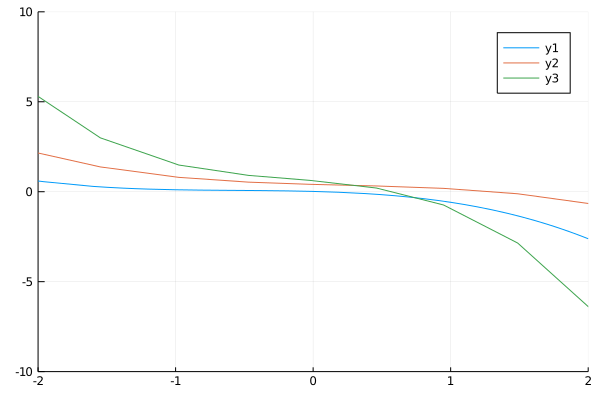

In [3]:
# wをいくつかサンプリングし、xの3次関数を図示する。

w1 = rand(w_dist)
w2 = rand(w_dist)
w3 = rand(w_dist)
plot(x -> model_sample(w1,x), xlim=(-2.,2.), ylim=(-10.,10.))
plot!(x -> model_sample(w2,x))
plot!(x -> model_sample(w3,x))

このように学習前にモデルの性質を確かめるのも重要な作業である。

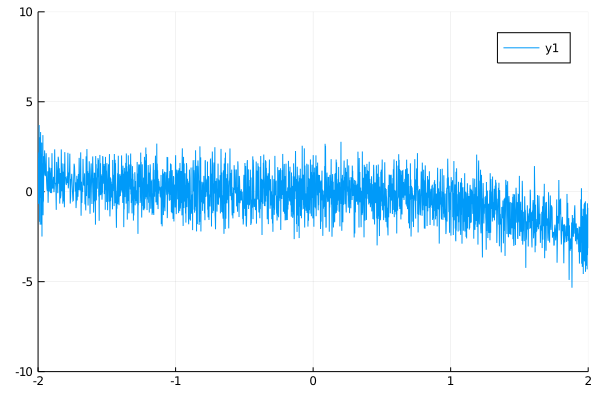

In [4]:
# 誤差を加え、実現値の範囲をみる。
plot(x -> rand(Normal(model_sample(w1,x),1)), xlim=(-2.,2.), ylim=(-10.,10.))

## 学習

モデルの事後分布は観測された変数の確率分布で割ることで求まる。観測された変数の確率分布は$p({\bf Y}|{\bf X})$であるから、

$$
\begin{eqnarray}
    p({\bf w}|{\bf Y},{\bf X}) &=& \frac{p({\bf w}) \Pi_{n=1}^{N} p (y_n | {\bf x}_n, {\bf w})}{p({\bf Y}|{\bf X})} \\
    &\propto& p({\bf w}) \Pi_{n=1}^{N} p (y_n | {\bf x}_n, {\bf w})
\end{eqnarray}
$$

これを${\bf w}$について整理していく。対数をとって

$$
\begin{eqnarray}
\ln p({\bf w}|{\bf Y},{\bf X}) &=& - \frac{1}{2} \{ ({\bf w} - {\bf m})^\mathrm{T} {\bf \Lambda} ({\bf w} - {\bf m}) \} - \frac{\lambda}{2} \Sigma_{n=1}^{N}  (y_n - {\bf w}^\mathrm{T} {\bf x}_n )^2 + const. \\
&=& - \frac{1}{2} \{ {\bf w}^\mathrm{T} {\bf \Lambda} {\bf w} - {\bf w}^\mathrm{T} {\bf \Lambda} {\bf m} -  {\bf m}^\mathrm{T} {\bf \Lambda} {\bf w} - 2 \lambda \Sigma_{n=1}^{N} y_n {\bf w}^\mathrm{T} {\bf x}_n + \lambda \Sigma_{n=1}^{N} {\bf w}^\mathrm{T} {\bf x}_n {\bf w}^\mathrm{T} {\bf x}_n \} + const. \\
&=& - \frac{1}{2} \{ {\bf w}^\mathrm{T} {\bf \Lambda} {\bf w} - 2 {\bf w}^\mathrm{T} {\bf \Lambda} {\bf m} - 2 \lambda \Sigma_{n=1}^{N} y_n {\bf w}^\mathrm{T} {\bf x}_n + \lambda \Sigma_{n=1}^{N} {\bf w}^\mathrm{T} {\bf x}_n {\bf x}_n^\mathrm{T} {\bf w} \} + const.　(スカラーを転置してまとめた) \\
&=& - \frac{1}{2} \{ {\bf w}^\mathrm{T} (\lambda \Sigma_{n=1}^{N} {\bf x}_n {\bf x}_n^\mathrm{T} + {\bf \Lambda}) {\bf w} - 2 {\bf w}^\mathrm{T} (\lambda \Sigma_{n=1}^{N} y_n {\bf x}_n + {\bf \Lambda} {\bf m}) \} + const.
\end{eqnarray}
$$

これはM次元のガウス分布の対数をとった形になっているので、パラメータ${\bf w}$の事後分布もM次元ガウス分布であり、

$$
\begin{eqnarray}
    p({\bf w}|{\bf Y},{\bf X}) &=& \mathcal{N}({\bf w}|\hat{\bf m}, \hat{\bf \Lambda}^{-1}) \\
    ただし　\hat{\bf \Lambda} &=& \lambda \Sigma_{n=1}^{N} {\bf x}_n {\bf x}_n^\mathrm{T} + {\bf \Lambda} \\
    \hat{\bf m} &=& \hat{\bf \Lambda}^{-1} (\lambda \Sigma_{n=1}^{N} y_n {\bf x}_n + {\bf \Lambda} {\bf m})
\end{eqnarray}
$$

## 予測

新規入力値${\bf x}_*$が与えられた時の出力$y_*$の予測分布$p(y_*|{\bf x}_*, {\bf Y}, {\bf X}$を求める。事前分布と事後分布は共にM次元ガウス分布であるので、事前分布のパラメータを使用した事前予測分布を求めてから事後分布のパラメータを代入し事後予測分布を求める。ベイズの定理から、

$$
p({\bf w} | y_*, {\bf x}_*) = \frac{p({\bf w})p(y_* | {\bf x}_*, {\bf w})}{p(y_*|{\bf x}_*)}
$$

よって

$$
\ln p(y_*|{\bf x}_*) = \ln p(y_* | {\bf x}_*, {\bf w}) - \ln p({\bf w} | y_*, {\bf x}_*) + const.
$$

と表せる。$p({\bf w} | y_*, {\bf x}_*)$は事後分布の計算結果を流用して

$$
\begin{eqnarray}
    p({\bf w} | y_*, {\bf x}_*) &=& \mathcal{N}({\bf w}|{\bf m}(y_*), (\lambda {\bf x}_n {\bf x}_n^\mathrm{T} + {\bf \Lambda})^{-1}) \\
    ただし　{\bf m}(y_*) &=& (\lambda {\bf x}_n {\bf x}_n^\mathrm{T} + {\bf \Lambda})^{-1} (\lambda y_* {\bf x}_* + {\bf \Lambda} {\bf m})
\end{eqnarray}
$$

であり、これを代入して、

$$
\begin{eqnarray}
    \ln p(y_*|{\bf x}_*) &=& \ln p(y_* | {\bf x}_*, {\bf w}) - \ln p({\bf w} | y_*, {\bf x}_*) + const. \\
    &=& - \frac{1}{2} (y_* - {\bf w}^\mathrm{T} {\bf x}_*)^2 \lambda + \frac{1}{2} ({\bf w} - {\bf m}(y_*))^\mathrm{T} (\lambda {\bf x}_n {\bf x}_n^\mathrm{T} + {\bf \Lambda}) ({\bf w} - {\bf m}(y_*)) + const. \\
    &=& - \frac{1}{2} \{ \lambda y_*^2  - 2 \lambda {\bf w}^\mathrm{T} {\bf x}_* y_* + 2{\bf w}^\mathrm{T} (\lambda {\bf x}_n {\bf x}_n^\mathrm{T} + {\bf \Lambda}) {\bf m}(y_*) - {\bf m}(y_*)^\mathrm{T} (\lambda {\bf x}_n {\bf x}_n^\mathrm{T} + {\bf \Lambda}) {\bf m}(y_*) \} + const. \\
    &=& - \frac{1}{2} \left[ \lambda y_*^2  - 2 \lambda {\bf w}^\mathrm{T} {\bf x}_* y_* + 2 {\bf w}^\mathrm{T} (\lambda y_* {\bf x}_* + {\bf \Lambda} {\bf m}) - \{(\lambda {\bf x}_* {\bf x}_*^\mathrm{T} + {\bf \Lambda})^{-1} (\lambda y_* {\bf x}_* + {\bf \Lambda} {\bf m})\}^\mathrm{T} (\lambda y_* {\bf x}_* + {\bf \Lambda} {\bf m}) \right] + const. \\
    &=& - \frac{1}{2} \{ \lambda y_*^2 - (\lambda y_* {\bf x}_* + {\bf \Lambda} {\bf m})^\mathrm{T} (\lambda {\bf x}_* {\bf x}_*^\mathrm{T} + {\bf \Lambda})^{-1} (\lambda y_* {\bf x}_* + {\bf \Lambda} {\bf m}) \} + const. \\
    &=& - \frac{1}{2} \{ \lambda y_*^2 - \lambda^2 {\bf x}_*^\mathrm{T} (\lambda {\bf x}_* {\bf x}_*^\mathrm{T} + {\bf \Lambda})^{-1} {\bf x}_* y_*^2 - 2 {\bf x}_*^\mathrm{T} \lambda (\lambda {\bf x}_* {\bf x}_*^\mathrm{T} + {\bf \Lambda})^{-1} {\bf \Lambda} {\bf m} y_* \} + const. \\
    &=& - \frac{1}{2} \{ (\lambda - \lambda^2 {\bf x}_*^\mathrm{T} (\lambda {\bf x}_* {\bf x}_*^\mathrm{T} + {\bf \Lambda})^{-1} {\bf x}_*) y_*^2 - 2 {\bf x}_*^\mathrm{T} \lambda (\lambda {\bf x}_* {\bf x}_*^\mathrm{T} + {\bf \Lambda})^{-1} {\bf \Lambda} {\bf m} y_* \} + const.
\end{eqnarray}
$$

と$y_*$の2次関数に変形できる。これは次のような1次元ガウス分布の対数をとったものである。


$$
\begin{eqnarray}
    p(y_*|{\bf x}_*) &=& \mathcal{N}(y_* | \mu_*, \lambda_*^{-1}) \\
    ただし　\mu_* &=& {\bf m}^\mathrm{T} {\bf x}_* \\
    \lambda_*^{-1} &=& \lambda^{-1} + {\bf x}_*^\mathrm{T} {\bf \Lambda}^{-1} {\bf x}_*
\end{eqnarray}
$$

$\mu_*, \lambda_*$はウッドベリーの公式$({\bf A}+{\bf UBV})^{-1} = {\bf A}^{-1} - {\bf A}^{-1} {\bf U} ({\bf B}^{-1} + {\bf VA}^{-1} {\bf U})^{-1} {\bf VA}^{-1}$を使って導ける。導出を次に示す。

$$
\begin{eqnarray}
    \ln \mathcal{N}(y_* | \mu_*, \lambda_*^{-1}) &=& - \frac{1}{2} (y_* - \mu_*)^2 \lambda_* + const. \\
    &=& - \frac{1}{2} \{ \lambda_* y_*^2 - 2 \lambda_* \mu_* y_*\} + const. \\
    対応から　\lambda_* &=& \lambda - \lambda^2 {\bf x}_*^\mathrm{T} (\lambda {\bf x}_* {\bf x}_*^\mathrm{T} + {\bf \Lambda})^{-1} {\bf x}_*
\end{eqnarray}
$$

${\bf A} = \lambda^{-1}, {\bf B} = {\bf \Lambda}^{-1}, {\bf U} = {\bf x}_*^\mathrm{T}, {\bf V} = {\bf x}_*$とおくと、ウッドベリーの公式から

$$
\lambda_* = (\lambda^{-1} + {\bf x}_*^\mathrm{T} {\bf \Lambda}^{-1} {\bf x}_*)^{-1}
$$

また$\mu_*$については対応とウッドベリーの公式から

$$
\begin{eqnarray}
    \mu_* \lambda_* &=& {\bf x}_*^\mathrm{T} \lambda (\lambda {\bf x}_* {\bf x}_*^\mathrm{T} + {\bf \Lambda})^{-1} {\bf \Lambda} {\bf m} \\
    &=& {\bf x}_*^\mathrm{T} \lambda ({\bf \Lambda}^{-1} - {\bf \Lambda}^{-1} {\bf x}_* (\lambda^{-1} + {\bf x}_*^\mathrm{T} {\bf \Lambda}^{-1} {\bf x}_*)^{-1} {\bf x}_*^\mathrm{T} {\bf \Lambda}^{-1}) {\bf \Lambda} {\bf m} \\
    &=& {\bf x}_*^\mathrm{T} \lambda {\bf m} - {\bf x}_*^\mathrm{T} \lambda {\bf \Lambda}^{-1} {\bf x}_* (\lambda^{-1} + {\bf x}_*^\mathrm{T} {\bf \Lambda}^{-1} {\bf x}_*)^{-1} {\bf x}_*^\mathrm{T} {\bf m}
\end{eqnarray}
$$

$\lambda_*{-1}$をかけて

$$
\begin{eqnarray}
    \mu_* &=& {\bf x}_*^\mathrm{T} {\bf m} + {\bf x}_*^\mathrm{T} \lambda {\bf m} {\bf x}_*^\mathrm{T} {\bf \Lambda}^{-1} {\bf x}_* - {\bf x}_*^\mathrm{T} \lambda {\bf \Lambda}^{-1} {\bf x}_* {\bf x}_*^\mathrm{T} {\bf m}　({\bf x}_*^\mathrm{T} {\bf m}がスカラーであることを利用)\\
    &=& {\bf m}^\mathrm{T} {\bf x}_*
\end{eqnarray}
$$

となり導出完了。

## モデル比較

モデルの性能を比較するための定量的な方法として、周辺尤度(marginal likelihood)あるいはモデルエビデンス(model evidence)というものがある。これは観測変数$\mathcal{D}$がモデルから生成される確率$p(\mathcal{D})$に当たる。今回の線形回帰の例で言えば$p({\bf Y}|{\bf X})$を求めることになる。

$$
p({\bf Y}|{\bf X}) = \frac{p({\bf w}) \Pi_{n=1}^{N} p (y_n | {\bf x}_n, {\bf w})}{p({\bf w}|{\bf Y},{\bf X})} 
$$

対数をとり、具体的な分布を代入していく。

$$
\begin{eqnarray}
    \ln p({\bf Y}|{\bf X}) &=& \ln p({\bf w}) + \ln \Sigma_{n=1}^{N} p (y_n | {\bf x}_n, {\bf w}) - \ln p({\bf w}|{\bf Y},{\bf X}) \\
    &=& - \frac{1}{2} \{ ({\bf w} - {\bf m})^\mathrm{T} {\bf \Lambda} ({\bf w} - {\bf m}) - \ln |{\bf \Lambda}| + M \ln 2 \pi \} - \frac{1}{2} \Sigma_{n=1}^{N} \{ \ln 2 \pi - \ln \lambda + (y_n - {\bf w}^\mathrm{T} {\bf x}_n)^2 \lambda \} + \frac{1}{2} \{ ({\bf w} - \hat{\bf m})^\mathrm{T} \hat{\bf \Lambda} ({\bf w} - \hat{\bf m}) - \ln | \hat{\bf \Lambda} | + M \ln 2 \pi \} \\
    &=& - \frac{1}{2} \{ \Sigma_{n=1}^{N}(\lambda y_n^2 - \ln \lambda + \ln 2 \pi) + {\bf m}^\mathrm{T} {\bf \Lambda} {\bf m} - \ln |{\bf \Lambda}| - \hat{\bf m}^\mathrm{T} \hat{\bf \Lambda} \hat{\bf m} + \ln |\hat{\bf \Lambda}| + {\bf w}^\mathrm{T} {\bf \Lambda} {\bf w} - 2 {\bf w}^\mathrm{T} {\bf \Lambda} {\bf m} - {\bf w}^\mathrm{T} \hat{\bf \Lambda} {\bf w} + 2 {\bf w}^\mathrm{T} \hat{\bf \Lambda} \hat{\bf m} - 2 \lambda {\bf w}^\mathrm{T} \Sigma_{n=1}^{N} y_n {\bf x}_n + \lambda \Sigma_{n=1}^{N} {\bf w}^\mathrm{T} {\bf x}_n {\bf x}_n^\mathrm{T} {\bf w} \} \\
    &=& - \frac{1}{2} \{ \Sigma_{n=1}^{N}(\lambda y_n^2 - \ln \lambda + \ln 2 \pi) + {\bf m}^\mathrm{T} {\bf \Lambda} {\bf m} - \ln |{\bf \Lambda}| - \hat{\bf m}^\mathrm{T} \hat{\bf \Lambda} \hat{\bf m} + \ln |\hat{\bf \Lambda}| - {\bf w}^\mathrm{T} \lambda \Sigma_{n=1}^{N} {\bf x}_n {\bf x}_n^\mathrm{T} {\bf w} + 2 {\bf w}^\mathrm{T} \lambda \Sigma_{n=1}^{N} y_n {\bf x}_n - 2 \lambda {\bf w}^\mathrm{T} \Sigma_{n=1}^{N} y_n {\bf x}_n + \lambda \Sigma_{n=1}^{N} {\bf w}^\mathrm{T} {\bf x}_n {\bf x}_n^\mathrm{T} {\bf w} \} \\
    &=& - \frac{1}{2} \{ \Sigma_{n=1}^{N}(\lambda y_n^2 - \ln \lambda + \ln 2 \pi) + {\bf m}^\mathrm{T} {\bf \Lambda} {\bf m} - \ln |{\bf \Lambda}| - \hat{\bf m}^\mathrm{T} \hat{\bf \Lambda} \hat{\bf m} + \ln |\hat{\bf \Lambda}| \}
\end{eqnarray}
$$

と、整理できる。

## Juliaで実装

In [5]:
mutable struct LinearModel
    M::Int
    m::Vector
    Λ::Matrix
end  

function init(model::LinearModel)
    model.m = zeros(model.M)
    model.Λ = I(model.M)
    return model
end

function predict(model::LinearModel, x_new::Float64)
    x_vec = [x_new^m for m in 0:model.M-1]
    μ_pred = model.m' * x_vec
    σ_new = sqrt(1/λ + x_vec' * inv(model.Λ) * x_vec)
    pred_dist = Normal(μ_pred, σ_new)
    return pred_dist
end 

predict (generic function with 1 method)

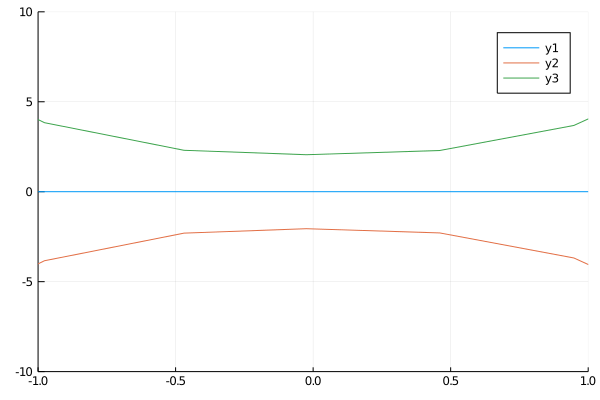

In [6]:
λ = 10
model = LinearModel(4, zeros(4), I(4))
model = init(model)
plot(x -> mean(predict(model, x)), xlim=(-1,1), ylim=(-10,10))
plot!(x -> quantile(predict(model, x), 0.025))
plot!(x -> quantile(predict(model, x), 0.975))

In [7]:
function fit(model, xs, ys)
    N = length(xs)
    x_ns = [[x^m for m in 0:model.M-1] for x in xs]
    Λ̂ = λ * sum(x_ns .* transpose.(x_ns)) + model.Λ
    m̂ = inv(Λ̂)*(λ * sum(ys .* x_ns) + model.Λ * model.m)
    evidence = - 0.5 * (λ*sum(ys.^2) - N*log(λ) + N*log(2*π) + model.m'*model.Λ*model.m - log(det(model.Λ)) - m̂'*Λ̂*m̂ + log(det(Λ̂)))
    model.m = m̂
    model.Λ = Λ̂
    return model, evidence
end

fit (generic function with 1 method)

In [8]:
# sinカーブ上の点を生成
xs = collect(0:π/10:2π)
ys = sin.(xs)
λ = 10

10

In [9]:
function simulation(M)
    model = LinearModel(M, zeros(1), I(1))
    model = init(model)
    model, evidence = fit(model, xs, ys)
    p = scatter(xs, ys, xlim=(-π,3π), ylim=(-3,3))
    plot!(p, x -> mean(predict(model, x)), xlim=(-π,3π))
    plot!(p, x -> quantile(predict(model, x), 0.025), xlim=(-π,3π))
    plot!(p, x -> quantile(predict(model, x), 0.975), xlim=(-π,3π))
    return p, evidence
end

simulation (generic function with 1 method)

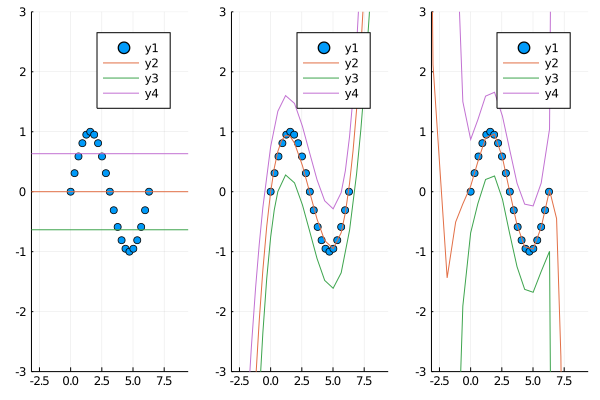

In [10]:
# M=1,4,10の場合でプロット
p1, evi1 = simulation(1)
p4, evi4 = simulation(4)
p10, evi10 = simulation(10)
plot(p1, p4, p10, layout=(1,3))

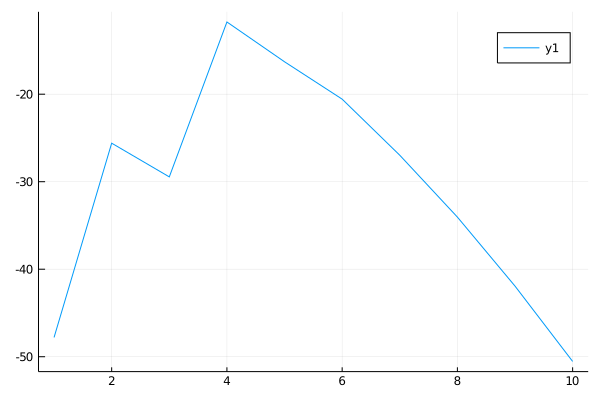

In [11]:
# モデルエビデンスをプロット
plot(collect(1:10), [simulation(M)[2] for M in 1:10])

┌ Info: Saved animation to 
│   fn = /Users/tomoyamiyagi/Projects/tpt-medical-it/_notebooks/animations/linear_reg.gif
└ @ Plots /Users/tomoyamiyagi/.julia/packages/Plots/EJmJT/src/animation.jl:102


Plots.AnimatedGif("/Users/tomoyamiyagi/Projects/tpt-medical-it/_notebooks/animations/linear_reg.gif")
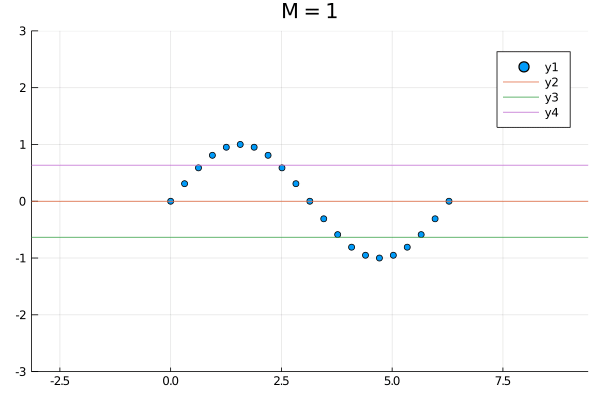

In [12]:
#hide_output
# animation
anim = @animate for M in 1:10
    p, evi = simulation(M)
    plot(p, title="M = $(M)")
end

gif(anim, "animations/linear_reg.gif", fps = 2)

![](animations/linear_reg.gif)

## おまけ:MAP推定とL2正則化

MAP推定は事後確率を最大にするような値をパラメータの値にする推定である。

線形モデルでは$p({\bf w}|{\bf Y},{\bf X})$を最大化する${\bf w}$を求めることになる。対数事後確率を最大にするパラメータも同じなので$\ln p({\bf w}|{\bf Y},{\bf X})$を最大化すればいい。

ただし、${\bf m} = {\bf 0}, \lambda = \sigma_y^{-2}, \Lambda = \sigma_w^{-2} I$とする。

$$
\begin{eqnarray}
    \ln p({\bf w}|{\bf Y},{\bf X}) &=& \ln p({\bf Y}|{\bf X},{\bf w}) + \ln p({\bf w}) + const. \\
    &=& \Sigma_{n=1}^{N} \ln \mathcal{N}(y_n | {\bf w}^\mathrm{T} {\bf x}_n, \lambda) + \ln \mathcal{N}({\bf w}|{\bf m},{\bf \Lambda}^{-1}) + const. \\
    &=& - \frac{\lambda}{2} \Sigma_{n=1}^{N} (y_n - {\bf w}^\mathrm{T} {\bf x}_n)^2 - \frac{1}{2} ({\bf w}-{\bf m})^\mathrm{T} {\bf \Lambda} ({\bf w}-{\bf m}) + const. \\
    &=& - \sigma_y^{-2} \{ \frac{1}{2} \Sigma_{n=1}^{N} (y_n - {\bf w}^\mathrm{T} {\bf x}_n)^2 + \frac{\sigma_w^{-2}}{\sigma_y^{-2}} \frac{1}{2} {\bf w}^\mathrm{T} {\bf w} \} + const.
\end{eqnarray}
$$

と式変形でき、$\frac{1}{2} \Sigma_{n=1}^{N} (y_n - {\bf w}^\mathrm{T} {\bf x}_n)^2 + \frac{\sigma_w^{-2}}{\sigma_y^{-2}} \frac{1}{2} {\bf w}^\mathrm{T} {\bf w}$の部分はL2正則化で最小化する損失関数と等価である。

したがって、L2正則化はMAP推定の特別な場合であり、その正則化項の係数はMAP推定における事前分布のパラメータ(ハイパーパラメータ)として解釈できる。

{{ '[須山敦志. 杉山将. ベイズ推論による機械学習入門. 講談社, 2017.](https://www.kspub.co.jp/book/detail/1538320.html)' | fndetail: 1 }}